# Gill-Matsuno model

The Gill-Matsuno model is a classical atmospheric model that describes the tropical atmospheric response to a prescribed heating. It consists of 3 prognostic variables $u$, $v$, and $\phi$ in an equatorial beta-plane approximation. The non-dimensional form of the equations is given by:

$$
\frac{\partial u}{\partial t} + eu - \frac{1}{2} yv = -\frac{\partial \phi}{\partial x}
$$
$$
\frac{\partial v}{\partial t} + ev + \frac{1}{2} yu = -\frac{\partial \phi}{\partial y}
$$
$$
\frac{\partial \phi}{\partial t} + e\phi + \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = Q
$$

This cookbook aims to reproduce the results of the classical Gill-Matsuno model experiment in different forcing scenarios. The model is set up on a grid with prescribed parameters, and the forcing function $Q$ is defined to represent the heating in the atmosphere. Here we will explore the steady-state solution of the set of equations outline above, which is often used to analyze the tropical atmospheric dynamics in a simplified manner.

<!-- For the Gill-Matsuno model, we look for the steady-state solution, which means we set the time derivatives to zero, further simplifying the equations. This set of equations represents the balance between the horizontal momentum equations and the continuity equation in the context of a tropical atmosphere.

$$
eu - \frac{1}{2} yv = -\frac{\partial \phi}{\partial x}
$$
$$
ev + \frac{1}{2} xu = -\frac{\partial \phi}{\partial y}
$$
$$
e\phi + \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = Q
$$ -->


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numba

In [ ]:
@numba.njit
def numba_solver_loop(u, v, p, Q, yy, dt, dx, dy, eps_u, eps_v, eps_p, max_steps, stop_del):
    """
    Performs the core time-stepping loop.
    This function is JIT-compiled by Numba for maximum performance.
    """
    x_dim, y_dim = u.shape
    p_old = np.copy(p)

    # --- Main Timestepping Loop ---
    for n in range(max_steps):
        # Store the pressure field from the previous step
        p_old[:, :] = p

        # --- Calculate spatial derivatives using explicit loops for Numba ---
        du_dt = np.zeros_like(u)
        dv_dt = np.zeros_like(v)
        dp_dt = np.zeros_like(p)

        for i in range(1, x_dim - 1):
            for j in range(1, y_dim - 1):
                # Derivatives for the RHS calculation
                dp_dx = (p[i + 1, j] - p[i - 1, j]) / (2 * dx)
                dp_dy = (p[i, j + 1] - p[i, j - 1]) / (2 * dy)
                du_dx = (u[i + 1, j] - u[i - 1, j]) / (2 * dx)
                dv_dy = (v[i, j + 1] - v[i, j - 1]) / (2 * dy)
                
                # Calculate the right-hand side (RHS) of the equations
                du_dt[i, j] = -eps_u * u[i, j] + 0.5 * yy[i, j] * v[i, j] - dp_dx
                dv_dt[i, j] = -eps_v * v[i, j] - 0.5 * yy[i, j] * u[i, j] - dp_dy
                dp_dt[i, j] = -eps_p * p[i, j] - (du_dx + dv_dy) + Q[i, j]

        # --- Update state with Forward Euler Step ---
        u += du_dt * dt
        v += dv_dt * dt
        p += dp_dt * dt

        # --- Apply Boundary Conditions ---
        u[0, :], u[-1, :] = u[-2, :], u[1, :]
        v[0, :], v[-1, :] = v[-2, :], v[1, :]
        p[0, :], p[-1, :] = p[-2, :], p[1, :]
        u[:, 0], u[:, -1] = u[:, 1], u[:, -2]
        v[:, 0], v[:, -1] = v[:, 1], v[:, -2]
        p[:, 0], p[:, -1] = p[:, 1], p[:, -2]

        # --- Check for Convergence ---
        if n % 100 == 0:
            delta_p = p - p_old
            mean_change = np.mean(delta_p)
            max_abs_change = np.max(np.abs(delta_p))
            
            if (np.abs(mean_change) < stop_del) and (max_abs_change < stop_del * 10):
                print(f"Convergence reached at step {n+1}!")
                return u, v, p

    print("Reached max simulation steps. The solution may not have converged.")
    return u, v, p

In [86]:
def setup_grid_and_forcing(params):
    """Initializes the grid, state variables, and heating function Q."""
    Lx, Ly = params['Lx'], params['Ly']
    dx, dy = params['dx'], params['dy']
    xs = np.arange(0, Lx + dx, dx)
    ys = np.arange(-Ly, Ly + dy, dy)
    x_dim, y_dim = len(xs), len(ys)
    xx, yy = np.meshgrid(xs, ys, indexing='ij')
    u, v, p = np.zeros((x_dim, y_dim)), np.zeros((x_dim, y_dim)), np.zeros((x_dim, y_dim))
    Q = np.zeros((x_dim, y_dim))
    L_forcing = 2.0
    heating_mask = (xx > 4 * L_forcing) & (xx < 6 * L_forcing)
    # sin( pi /(2*L) * x) * exp(-1/4 * y^2)
    Q[heating_mask] = (np.sin(np.pi / (2 * L_forcing) * xx[heating_mask]) *
                       np.exp(-0.25 * yy[heating_mask]**2)) * -1
    grid = {'xs': xs, 'ys': ys, 'xx': xx, 'yy': yy, 'x_dim': x_dim, 'y_dim': y_dim}
    return u, v, p, Q, grid

In [96]:
def solve_gill_model(params):
    """
    Main orchestrator function that sets up the model and calls the Numba solver.
    """
    u, v, p, Q, grid = setup_grid_and_forcing(params)
    yy = grid['yy']
    
    print("🚀 Starting simulation with Numba...")
    start_time = time.time()

    # Call the Numba-compiled solver, passing parameters individually
    u, v, p = numba_solver_loop(u, v, p, Q, yy,
                                params['dt'], params['dx'], params['dy'],
                                params['eps_u'], params['eps_v'], params['eps_p'],
                                params['max_steps'], params['stop_del'])
    
    end_time = time.time()
    print(f"Simulation finished in {end_time - start_time:.2f} seconds.")
    
    return u, v, p, grid

def plot_results(u, v, p, grid):
    """Visualizes the final steady-state solution."""
    xx, yy = grid['xx'], grid['yy']
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    contour = ax.contourf(xx.T, yy.T, p.T, levels=15, cmap='Blues_r')
    # fig.colorbar(contour, ax=ax, label='Pressure Anomaly (p)')
    ax.contour(xx.T, yy.T, p.T, levels=contour.levels, colors='k', linewidths=0.7)
    skip = (slice(None, None, 4), slice(None, None, 2))
    ax.quiver(xx[skip].T, yy[skip].T, u[skip].T, v[skip].T, color='black', scale=20)
    ax.set_title('Gill-Matsuno Model', fontsize=16)
    ax.set_xlabel('Zonal Distance (x)', fontsize=12)
    ax.set_ylabel('Meridional Distance (y)', fontsize=12)
    plt.show()

In [88]:
model_parameters = {
    'Lx': 25.0, 'Ly': 5.0,
    'dx': 0.5, 'dy': 0.5,
    'dt': 0.01,
    'eps_u': 0.1, 'eps_v': 0.1, 'eps_p': 0.1,
    'max_steps': 3000,
    'stop_del': 1e-5
}

In [89]:
u, v, p, Q, grid = setup_grid_and_forcing(model_parameters)

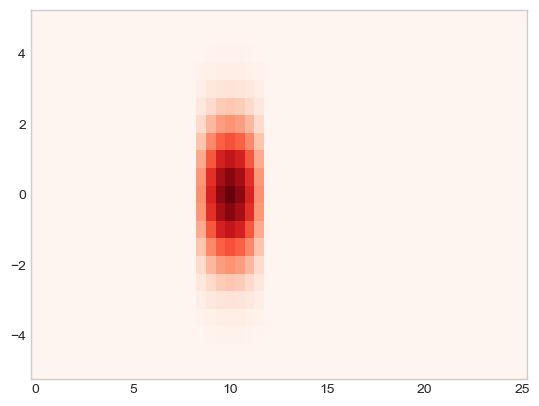

In [101]:
plt.pcolormesh(grid['xx'].T, grid['yy'].T, Q.T, cmap='Reds_r')

In [91]:
grid["yy"]

array([[-5. , -4.5, -4. , ...,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , ...,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , ...,  4. ,  4.5,  5. ],
       ...,
       [-5. , -4.5, -4. , ...,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , ...,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , ...,  4. ,  4.5,  5. ]], shape=(51, 21))

In [92]:
u_final, v_final, p_final, grid_info = solve_gill_model(model_parameters)

🚀 Starting simulation with Numba...
Reached max simulation steps. The solution may not have converged.
Simulation finished in 0.03 seconds.


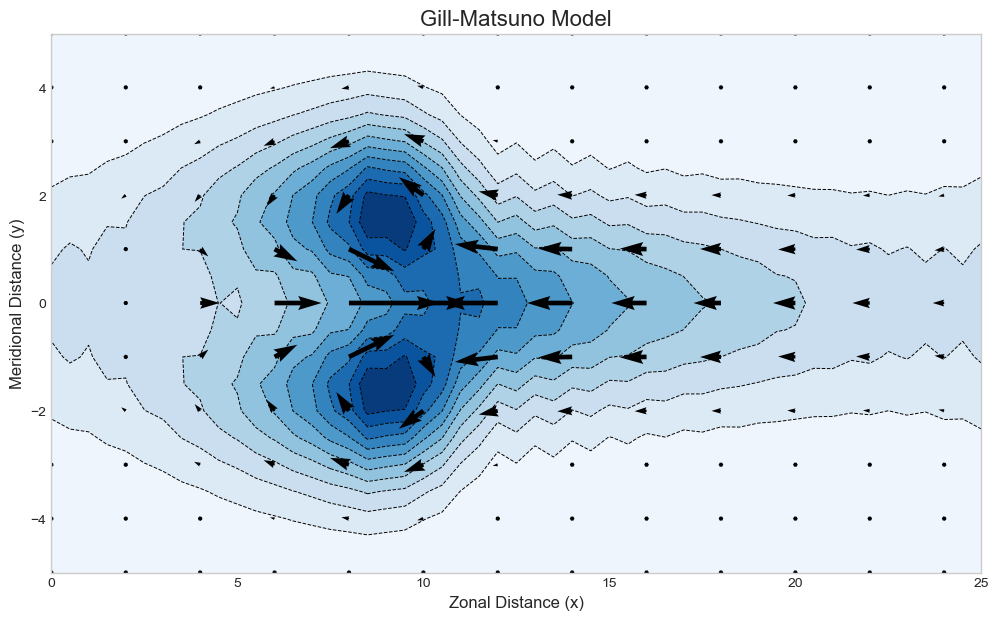

In [97]:
# Visualize the results
plot_results(u_final, v_final, p_final, grid_info)